In [10]:
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta

def parse_order_book_data(file_path):
    """
    Parse order book data from the given JSON file.
    """
    data_list = []
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract the 'data' array
    entries = data['data']

    for entry in entries:
        timestamp = entry['time_received']  # Assuming this is the timestamp
        # Convert timestamp string to datetime object
        timestamp = datetime.strptime(timestamp, '%H:%M:%S.%f')

        # Extract bids and asks
        bids = entry.get('bids', [])  # Each bid is [price, size]
        asks = entry.get('asks', [])  # Each ask is [price, size]

        data_list.append({
            'timestamp': timestamp,
            'bids': bids,
            'asks': asks
        })

    # Create DataFrame
    order_book_df = pd.DataFrame(data_list)
    order_book_df = order_book_df.head(150)
    return order_book_df

def calculate_order_book_metrics(order_book_df, N):
    """
    Calculate bid pressure, ask pressure, and imbalance for the order book.
    """
    metrics_list = []

    for index, row in order_book_df.iterrows():
        timestamp = row['timestamp']
        bids = row['bids']
        asks = row['asks']

        # Convert bids and asks to DataFrames
        bids_df = pd.DataFrame(bids, columns=['price', 'size'])
        asks_df = pd.DataFrame(asks, columns=['price', 'size'])
        bids_df = bids_df.head(150)
        asks_df = asks_df.head(150)

        # Ensure 'size' is numeric
        bids_df['size'] = bids_df['size'].astype(float)
        asks_df['size'] = asks_df['size'].astype(float)

        # Sort bids descending by price and get top N
        bids_df = bids_df.sort_values(by='price', ascending=False).head(N)

        # Sort asks ascending by price and get top N
        asks_df = asks_df.sort_values(by='price', ascending=True).head(N)

        # Calculate bid pressure and ask pressure
        bid_pressure = bids_df['size'].sum()
        ask_pressure = asks_df['size'].sum()

        # Calculate imbalance
        total_pressure = bid_pressure + ask_pressure
        if total_pressure != 0:
            imbalance = (bid_pressure - ask_pressure) / total_pressure
        else:
            imbalance = np.nan

        metrics_list.append({
            'timestamp': timestamp,
            'bid_pressure': bid_pressure,
            'ask_pressure': ask_pressure,
            'imbalance': imbalance
        })

    # Create DataFrame with metrics
    metrics_df = pd.DataFrame(metrics_list)
    return metrics_df

def parse_match_data(file_path):
    """
    Parse match data from the given JSON file.
    """
    data_list = []
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract the 'data' array
    entries = data['data']

    for entry in entries:
        timestamp = entry['time_received']  # Assuming this is the timestamp
        # Convert timestamp string to datetime object
        timestamp = datetime.strptime(timestamp, '%H:%M:%S.%f')

        price = float(entry['price'])
        size = float(entry['size'])
        side = entry['side']

        data_list.append({
            'timestamp': timestamp,
            'price': price,
            'size': size,
            'side': side
        })

    # Create DataFrame
    match_data_df = pd.DataFrame(data_list)
    return match_data_df

def calculate_match_data_metrics(match_data_df, interval_ms):
    """
    Calculate trade volume and trade speed for the match data.
    """
    # Set timestamp as index
    match_data_df = match_data_df.set_index('timestamp')

    # Resample data into intervals
    resampled_df = match_data_df.resample(f'{interval_ms}L').agg({
        'size': 'sum',       # Total trade volume
        'price': 'mean',     # Average price (optional)
        'side': 'count'      # Number of trades
    }).rename(columns={'size': 'trade_volume', 'side': 'trade_speed'})

    resampled_df = resampled_df.reset_index()
    return resampled_df

def synchronize_data(order_book_metrics_df, match_metrics_df):
    """
    Merge order book metrics and match data metrics on timestamp.
    """
    # Merge the DataFrames on timestamp
    merged_df = pd.merge_asof(
        order_book_metrics_df.sort_values('timestamp'),
        match_metrics_df.sort_values('timestamp'),
        on='timestamp',
        direction='nearest',
        tolerance=timedelta(milliseconds=50)
    )
    return merged_df


# Parameters
N = 5                # Number of top bids/asks to consider
interval_ms = 100    # Interval in milliseconds

# File paths
order_book_file = '/root/trading_systems/kucoin_dir/kucoin_release_data_initial/2024-12-02_10-00_QUILL/QUILL_level2Depth5_data.json'
match_data_file = '/root/trading_systems/kucoin_dir/kucoin_release_data_initial/2024-12-02_10-00_QUILL/QUILL_match_data.json'

# Parse data
order_book_df = parse_order_book_data(order_book_file)
match_data_df = parse_match_data(match_data_file)

# Calculate metrics
order_book_metrics_df = calculate_order_book_metrics(order_book_df, N)
match_metrics_df = calculate_match_data_metrics(match_data_df, interval_ms)

# Synchronize data
final_df = synchronize_data(order_book_metrics_df, match_metrics_df)

# Output final DataFrame
final_df



/tmp/ipykernel_1454186/4284691028.py:125: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  resampled_df = match_data_df.resample(f'{interval_ms}L').agg({


,timestamp,bid_pressure,ask_pressure,imbalance,trade_volume,price,trade_speed
0,1900-01-01 10:00:00.123600,5689.93,1104.53,0.674873,2951.06,0.939210,20
1,1900-01-01 10:00:00.149500,5689.93,1104.53,0.674873,2951.06,0.939210,20
2,1900-01-01 10:00:00.207400,40931.99,1936.82,0.909640,1222.00,1.257140,5
3,1900-01-01 10:00:00.313200,38091.00,1936.82,0.903226,3241.49,1.413537,19
4,1900-01-01 10:00:00.423600,10135.00,2341.20,0.624693,1617.00,1.571875,8
...,...,...,...,...,...,...,...
145,1900-01-01 10:00:15.414800,1621.47,232.17,0.749498,0.00,NaN,0
146,1900-01-01 10:00:15.521200,1621.47,275.47,0.709564,159.14,1.005760,5
147,1900-01-01 10:00:15.621400,1774.29,304.11,0.707361,18.22,1.094700,1
148,1900-01-01 10:00:15.727800,1714.06,306.73,0.696426,1.00,1.150000,1


In [11]:
final_df.head(50)

,timestamp,bid_pressure,ask_pressure,imbalance,trade_volume,price,trade_speed
0,1900-01-01 10:00:00.123600,5689.93,1104.53,0.674873,2951.06,0.939210,20
1,1900-01-01 10:00:00.149500,5689.93,1104.53,0.674873,2951.06,0.939210,20
2,1900-01-01 10:00:00.207400,40931.99,1936.82,0.909640,1222.00,1.257140,5
3,1900-01-01 10:00:00.313200,38091.00,1936.82,0.903226,3241.49,1.413537,19
4,1900-01-01 10:00:00.423600,10135.00,2341.20,0.624693,1617.00,1.571875,8
5,1900-01-01 10:00:00.521100,7356.00,3111.97,0.405430,1202.00,1.640000,5
6,1900-01-01 10:00:00.625500,5257.00,3844.56,0.155187,6.00,1.667167,6
7,1900-01-01 10:00:00.732700,5257.00,3840.56,0.155694,2.00,1.675000,2
8,1900-01-01 10:00:00.838900,5257.00,3838.56,0.155949,3.00,1.675000,3
9,1900-01-01 10:00:00.941500,5257.00,3833.56,0.156584,6.00,1.674483,6


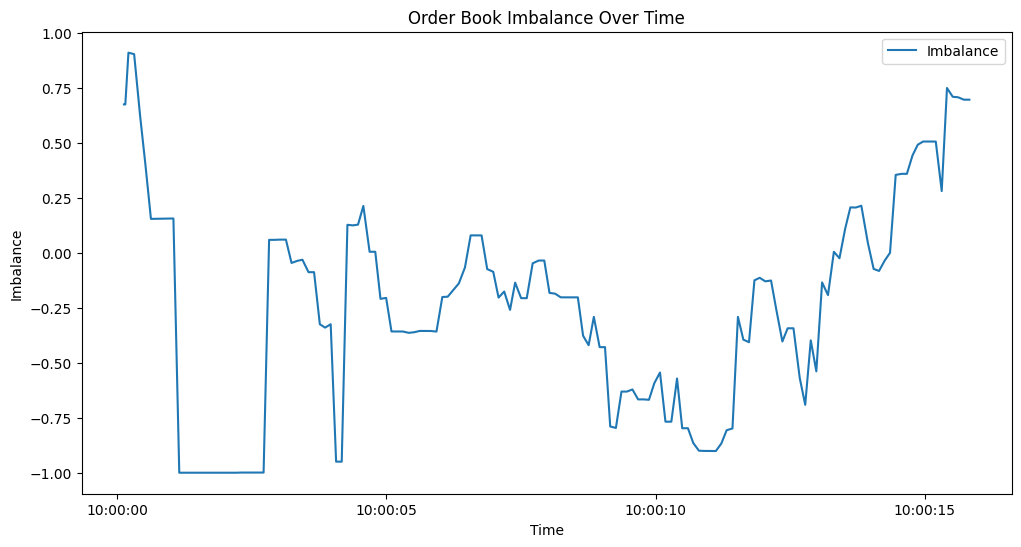

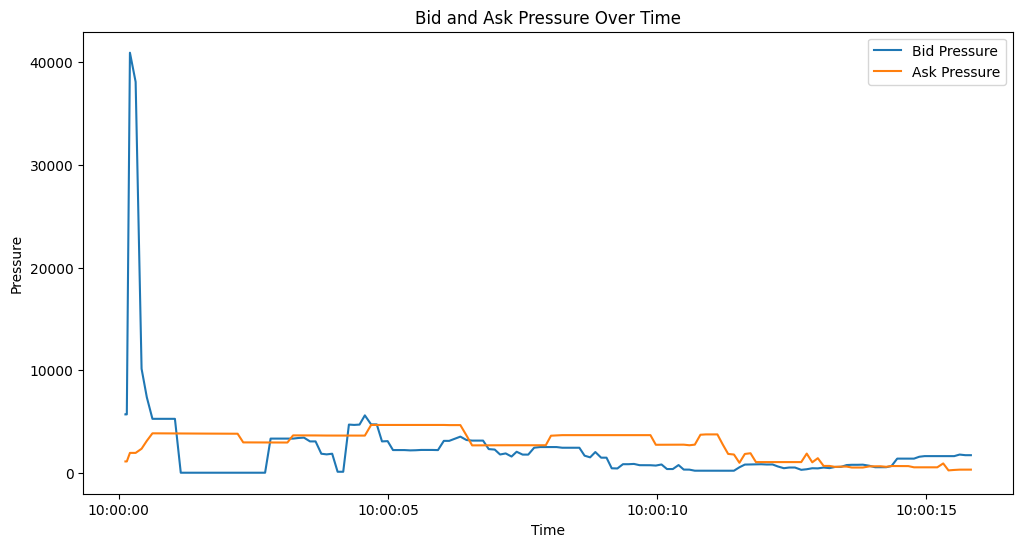

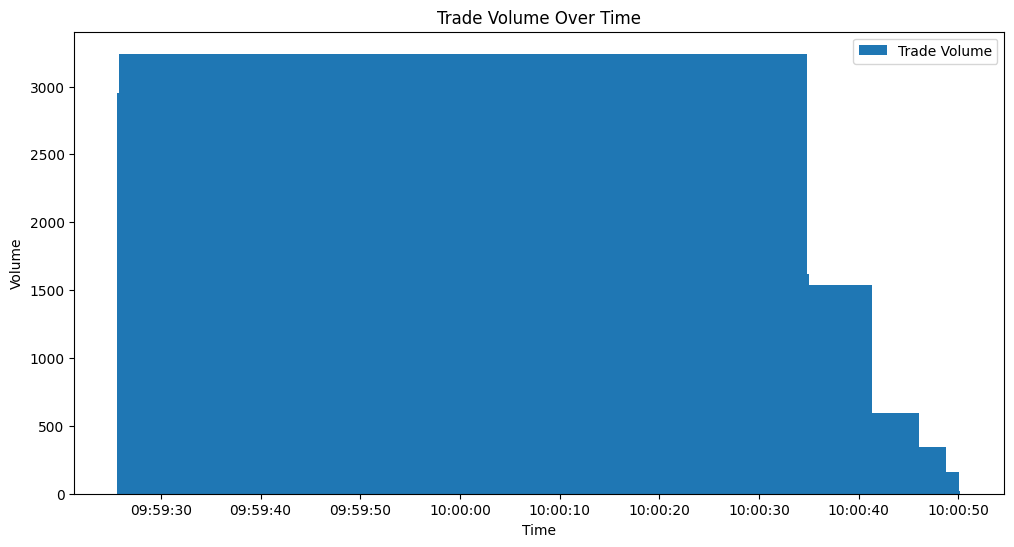

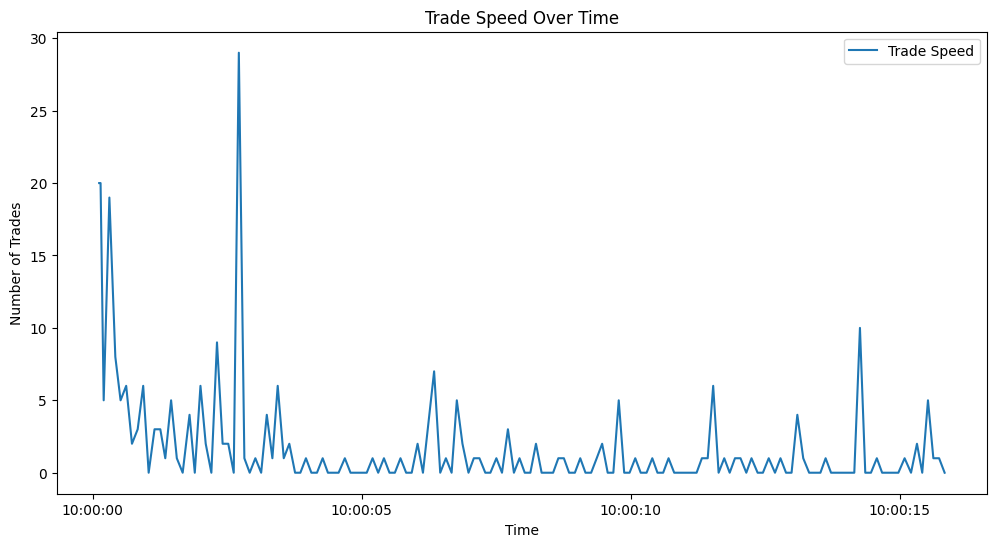

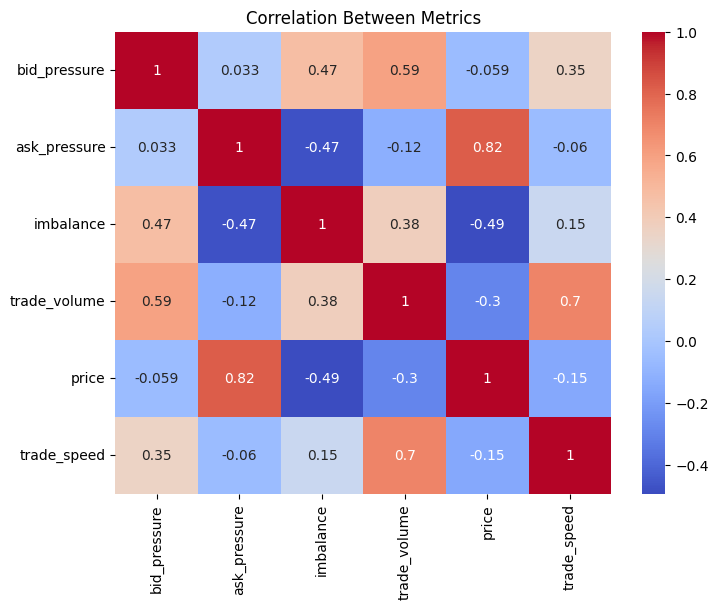

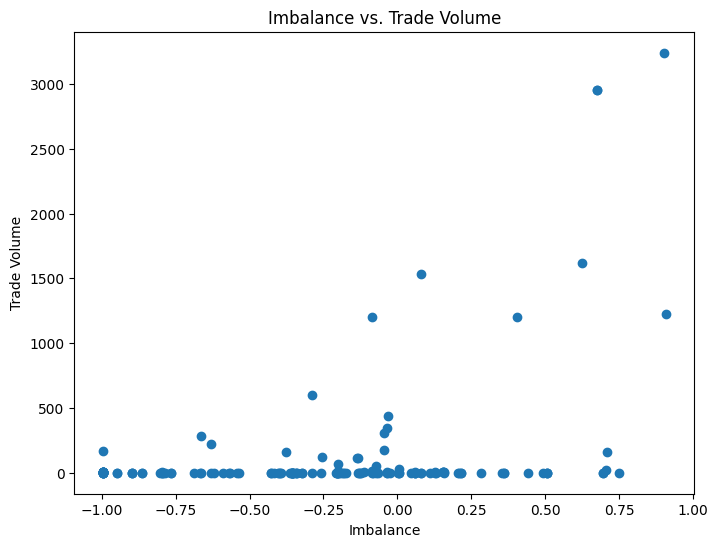

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_data(final_df):
    """
    Visualize the data using matplotlib and seaborn.
    """
    # Set the timestamp as the index
    final_df = final_df.set_index('timestamp')

    # Plot Imbalance over Time
    plt.figure(figsize=(12, 6))
    plt.plot(final_df.index, final_df['imbalance'], label='Imbalance')
    plt.title('Order Book Imbalance Over Time')
    plt.xlabel('Time')
    plt.ylabel('Imbalance')
    plt.legend()
    plt.show()

    # Plot Bid and Ask Pressure Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(final_df.index, final_df['bid_pressure'], label='Bid Pressure')
    plt.plot(final_df.index, final_df['ask_pressure'], label='Ask Pressure')
    plt.title('Bid and Ask Pressure Over Time')
    plt.xlabel('Time')
    plt.ylabel('Pressure')
    plt.legend()
    plt.show()

    # Plot Trade Volume Over Time
    plt.figure(figsize=(12, 6))
    plt.bar(final_df.index, final_df['trade_volume'], width=0.0008, label='Trade Volume')
    plt.title('Trade Volume Over Time')
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

    # Plot Trade Speed Over Time
    plt.figure(figsize=(12, 6))
    plt.plot(final_df.index, final_df['trade_speed'], label='Trade Speed')
    plt.title('Trade Speed Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Trades')
    plt.legend()
    plt.show()

    # Correlation Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(final_df.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Between Metrics')
    plt.show()

    # Scatter Plot of Imbalance vs. Trade Volume
    plt.figure(figsize=(8, 6))
    plt.scatter(final_df['imbalance'], final_df['trade_volume'])
    plt.title('Imbalance vs. Trade Volume')
    plt.xlabel('Imbalance')
    plt.ylabel('Trade Volume')
    plt.show()

visualize_data(final_df)